# Anime Recommendation: Collaborative Filtering Approach

## Overview
This project aims to build an anime recommendation system for new members and current subscribers of an anime streaming service. New members can use a content-based approach to receive recommendations based on a show they may have watched or heard of previosuly. For current subscribers, collaborative filtering is used by comparing the users' ratings and returning shows similar users have rated similarly. 


## Business Understanding

The anime industry is growing rapidly, with new shows being released all the time. This can make it difficult for anime fans to find new shows to watch that they will enjoy. Other general content streaming services such as Netflix, which has one of the best recommendation systems, has a substantial anime database as well as coming up with their very own productions. To keep up, anime streaming services should strive to use the technology available to keep improving their recommendations and in turn retain their viewers and market to new ones.

This project aims to build a recommendation system that will help anime fans discover new shows that they will enjoy. The recommendation system will provide a curated list of shows to users based on their content preferences and similar user's picks. The system will use a variety of factors to make its recommendations, including:

- The user's past viewing history
- The user's ratings of other shows
- The ratings of other users who have similar viewing habits
- The genre of the show
- Number of episodes the show has

The recommendation system will help anime fans save time by discovering new genres of anime and finding shows that are similar to their favorites. Anime fans will no longer have to spend hours searching for new shows to watch, as the recommendation system will suggest shows based on their past viewing history and the ratings of other users who have similar viewing habits. The system will also help anime fans discover new genres of anime that they may not have considered watching before. Additionally, the recommendation system will help anime fans find shows that are similar to their favorites, by suggesting other shows that are similar in tone, style, or genre.


## Collaborative Filtering
For collaborative filtering, I established a baseline using a normal predictor that predicts a random rating based on the distribution of the dataset. I then iterated through several Singular Value Decomposition (SVD) models, from which the final model was chosen. 
Singular value decomposition (SVD) is a matrix factorization technique that decomposes a matrix into two matrices of non-negative values. The first matrix, called the basis matrix, represents the underlying factors that explain the data. The second matrix, called the coefficient matrix, represents the weights of each factor in each data point.

SVD can be used to generate latent features by decomposing the sparse user-item interaction matrix into two smaller and dense matrices of user and item entities. The basis matrix represents the latent features of the users, while the coefficient matrix represents the weights of each latent feature for each item.

In [4]:
import pandas as pd
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#loading dataset
reviews = pd.read_csv('Data/cleaned_reviews.csv')
reviews

,Unnamed: 0,user_id,anime_id,rating
0,47,1,8074,10
1,81,1,11617,10
2,83,1,11757,10
3,101,1,15451,10
4,153,2,11771,10
...,...,...,...,...
6337236,7813732,73515,16512,7
6337237,7813733,73515,17187,9
6337238,7813734,73515,22145,10
6337239,7813735,73516,790,9


In [4]:
reviews.shape

(6337241, 4)

In [5]:
reviews.groupby('user_id').count().sort_values(by='rating')

,Unnamed: 0,anime_id,rating
user_id,,,
34856,1,1,1
52656,1,1,1
52654,1,1,1
3859,1,1,1
52641,1,1,1
...,...,...,...
51693,2621,2621,2621
59643,2632,2632,2632
57620,2689,2689,2689


In [6]:
# metadata
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6337241 entries, 0 to 6337240
Data columns (total 4 columns):
 #   Column      Dtype
---  ------      -----
 0   Unnamed: 0  int64
 1   user_id     int64
 2   anime_id    int64
 3   rating      int64
dtypes: int64(4)
memory usage: 193.4 MB


In [7]:
# sanity check for nulls
reviews.isna().sum()

Unnamed: 0    0
user_id       0
anime_id      0
rating        0
dtype: int64

In [8]:
# instantiating reader, 1-0 rating scale
reader = Reader(rating_scale=(1, 10))

# loading users df for train/test split
users = Dataset.load_from_df(reviews[['user_id', 'anime_id', 'rating']], reader)

# train/test split
trainset, testset = train_test_split(users, test_size=0.25, random_state=42)

### Baseline Models

In [14]:
baseline_normal = NormalPredictor()
baseline_normal.fit(trainset)

predictions = baseline_normal.test(testset)

normal_acc = accuracy.rmse(predictions)

RMSE: 2.1488


The normal predictor has high RMSE of 2.1488, which is to be expected since NornalPrector() predicts on random ratings.

In [15]:
# instantiating model
baseline_only = BaselineOnly()
baseline_only.fit(trainset)

# saving test predictions
predictions = baseline_only.test(testset)

base_acc = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 1.1922


The second baseline has a better RMSE, although for this project, I will use NormalPredictor() as a baseline as it acts more as a dummy model and will be a better comparison.

### Single Value Decomposition

In [27]:
svd_base = SVD(random_state=42)

results = cross_validate(svd_base, users, measures=['RMSE'], cv=3, n_jobs = -1, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1543  1.1522  1.1531  1.1532  0.0008  
Fit time          205.72  203.09  206.57  205.13  1.48    
Test time         17.45   17.57   17.19   17.40   0.16    


In [28]:
# fitting trainset
svd_base.fit(trainset)

# saving test predictions
predictions = svd_base.test(testset)

svd_base_acc = accuracy.rmse(predictions)

RMSE: 0.7772


The simmple SVD seems a promising final model due to the substancial decrease in error compared to the baselines. I will run grid searches to determine if improving the hyperparameters will be more benefitial for the model.

### SVD and Grid Searches

In [18]:
params_1 = {'n_factors':[5, 10], 'n_epochs': [10, 20], 'biased': [True, False]}

svd_grid_1 = GridSearchCV(SVD,param_grid=params_1,joblib_verbose=10, n_jobs=-1, cv=3)

svd_grid_1.fit(users)

svd_grid_1.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   4 out of  24 | elapsed:  1.5min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   7 out of  24 | elapsed:  2.5min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:  2.8min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  13 out of  24 | elapsed:  3.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed:  3.1min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:  4.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:  4.6min remaining:   24.8s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  4.7min finished


{'n_factors': 10, 'n_epochs': 20, 'biased': True}

In [19]:
# instantiating model with best params from search
svd_1 = SVD(n_factors=10, n_epochs=20, random_state=42)

# fitting to train set
svd_1.fit(trainset)

# getting test predictions
predictions = svd_1.test(testset)

# calculating and saving rmse
svd_1_acc = accuracy.rmse(predictions)

RMSE: 1.0357


This model is perfoming worse than the simple SVD based of the RMSE of 1.0357 even with the best hyperparameters found in the fist grid search. I will add more paramerters in the dictionary next.

In [20]:
# new gridsearch 
params_2 = {'n_factors':[10, 20], 'n_epochs': [20, 40],'lr_all': [0.05, .005], 
            'reg_all': [0.01, 0.02]}

svd_grid_2 = GridSearchCV(SVD,param_grid=params_2,joblib_verbose=10, n_jobs=-1, cv=3)


svd_grid_2.fit(users)
svd_grid_2.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  30 out of  48 | elapsed:  9.6min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  35 out of  48 | elapsed: 10.4min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  40 out of  48 | elapsed: 14.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  45 out of  48 | elapsed: 14.6min remaining:   58.5s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 14.9min finished


{'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}

In [21]:
# new model with best params from second gridsearch
svd_2 = SVD(n_factors=20, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)

# fitting to train set
svd_2.fit(trainset)

# getting test predictions
predictions = svd_2.test(testset)

# calculating and saving rmse
svd_2_acc = accuracy.rmse(predictions)

RMSE: 0.9833


This search shows some slight improvement compared to the previous one. However, it is still underperfoming compared to the simple SVD. I will continue grid searching with different parameters to determine if I can improve the RMSE further.

In [22]:
# new gridsearch 
params_3 = {'n_factors':[20,30],'n_epochs': [20,25],'lr_all': [0.05, .005, 0.001],
            'reg_all': [0.02, 0.03]}

svd_grid_3 = GridSearchCV(SVD,param_grid=params_3,joblib_verbose=10, n_jobs=-1, cv=3)


svd_grid_3.fit(users)
svd_grid_3.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed: 18.5min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed: 20.7min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 22.3min finished


{'n_factors': 30, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.03}

In [23]:
# new model with best params from second gridsearch
svd_3 = SVD(n_factors=30, n_epochs=20, lr_all=0.005, reg_all=0.03, random_state=42)

# fitting to train set
svd_3.fit(trainset)

# getting test predictions
predictions = svd_3.test(testset)

# calculating and saving rmse
svd_3_acc = accuracy.rmse(predictions)

RMSE: 0.9713


The RMSE seems to be improving slightly. To be certain, I will run one more search to determine the best model.

In [19]:
params_4 = {'n_factors':[30,40],'n_epochs': [25,30],'lr_all': [0.005, .001],
            'reg_all': [0.03, 0.05]}

svd_grid_4 = GridSearchCV(SVD,param_grid=params_4,joblib_verbose=10, n_jobs=-1, cv=3)


svd_grid_4.fit(users)
svd_grid_4.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  30 out of  48 | elapsed: 13.5min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done  35 out of  48 | elapsed: 14.3min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done  40 out of  48 | elapsed: 18.5min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  45 out of  48 | elapsed: 18.8min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 19.1min finished


{'n_factors': 40, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05}

In [13]:
# new model with best params from second gridsearch
svd_4 = SVD(n_factors=40, n_epochs=30, lr_all=0.005, reg_all=0.05, random_state=42)

# fitting to train set
svd_4.fit(trainset)

# getting test predictions
predictions = svd_4.test(testset)

# calculating and saving rmse
svd_4_acc = accuracy.rmse(predictions)

RMSE: 0.9571


After four different grid searches, the simple SVD and first model is sill the best one with the lowest RMSE.

### Non-Negative Matrix Factorization (NMF) Grid Seach 

In [24]:
# setting up serach for nmf
nmf_params_1 = {'n_factors':[5, 10],
             'n_epochs':[20, 30],
             'biased': [True, False]}

nmf_grid_1 = GridSearchCV(NMF, param_grid=nmf_params_1, cv=3, joblib_verbose=10, n_jobs=-1)


nmf_grid_1.fit(users)
nmf_grid_1.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   4 out of  24 | elapsed:  2.6min remaining: 12.8min
[Parallel(n_jobs=-1)]: Done   7 out of  24 | elapsed:  3.8min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:  4.1min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  13 out of  24 | elapsed:  4.9min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed:  5.2min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:  6.7min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:  7.1min remaining:   38.4s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  7.2min finished


{'n_factors': 5, 'n_epochs': 30, 'biased': True}

In [26]:
nmf_1 = NMF(n_factors=5, n_epochs=30, random_state=42, biased=True)
nmf_1.fit(trainset)
predictions = nmf_1.test(testset)
nmf_1_acc = accuracy.rmse(predictions)

RMSE: 1.1832


This model perfoms worse than all the SVD models with a slighly higher RMSE.

### SVDPP & Grid Search

In [23]:
svdpp_params = {'n_factors':[1, 5],
                    'n_epochs':[25, 50],
                    'reg_all':[0.02, 0.05]}
svdpp_grid_1 = GridSearchCV(SVDpp, param_grid=svdpp_params, cv=3, joblib_verbose=10, n_jobs=-1)

svdpp_grid_1.fit(users)
svdpp_grid_1.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [ ]:
svdpp_1 = SVDpp(n_factors=5, n_epochs=50, reg_all=0.02, random_state=42,)
svdpp_1.fit(trainset)
predictions = svdpp_1.test(testset)
svdpp_1_acc = accuracy.rmse(predictions)

RMSE: 1.6096


### Model Comparison
After many iterations of SVD models, the first basic model achived the lowest RMSE of 0.7772 and will be used as the final model for recommendations. I compared this RMSE to the results from the Normal and Baseline Only predictions used as baselines that had RMSEs of 2.1488 and 1.1922, respectively. 

In [7]:
X = ['Baseline', 'SVD', 'NMF', 'SVDpp']
y = [2.1488, 0.7772, 1.1832, 1.6096]

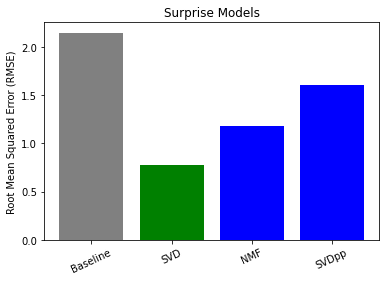

In [8]:
fig, ax = plt.subplots()
plt.bar(X, y, color=['grey', 'green', 'blue', 'blue'])
plt.xticks(rotation=25)
ax.set_title("Surprise Models")
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.savefig('Images/model_comparison.png', dpi=400);

## Building Recommendation Model
The following code was sourced from one of my instructor's projects, linked [here](https://github.com/danielburdeno/Kindle-eBook-Recommendations/blob/main/CollaborativeFiltering.ipynb), and adjusted for this model.

In [31]:
trainset = users.build_full_trainset()
svd_base.fit(trainset)

In [32]:
df_original = pd.read_csv('Data/anime_cleaned.csv', index_col='uid')
df_original.drop(columns =['Unnamed: 0'], inplace=True)
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15153 entries, 28891 to 16934
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     15153 non-null  object 
 1   synopsis  15153 non-null  object 
 2   genre     15153 non-null  object 
 3   episodes  15153 non-null  float64
 4   members   15153 non-null  int64  
 5   score     15153 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 828.7+ KB


In [33]:
df_original.head()

,title,synopsis,genre,episodes,members,score
uid,,,,,,
28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,8.82
23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,8.83
34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,8.83
5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,9.23
31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,8.83


In [38]:
user_ids = reviews.set_index('user_id')
user_ids.drop(columns=['Unnamed: 0', 'rating'], inplace=True)
user_ids.head()

,anime_id
user_id,
1,8074
1,11617
1,11757
1,15451
2,11771


In [39]:
user_ids.dtypes

anime_id    int64
dtype: object

In [40]:
user_ids.to_csv('Data/user_anime_df.csv')

In [43]:
user = input('UserID: ')
recs = int(input('Number of Recommendations: '))

In [45]:
reviewed = list(user_ids.loc[user, 'anime_id'])


[1,
 5,
 6,
 19,
 27,
 30,
 33,
 57,
 67,
 71,
 72,
 73,
 96,
 121,
 134,
 150,
 166,
 167,
 168,
 182,
 184,
 198,
 202,
 205,
 226,
 239,
 240,
 269,
 270,
 297,
 317,
 343,
 356,
 384,
 395,
 405,
 411,
 419,
 430,
 523,
 574,
 617,
 618,
 762,
 777,
 834,
 856,
 860,
 924,
 928,
 934,
 935,
 1013,
 1015,
 1165,
 1243,
 1361,
 1454,
 1482,
 1498,
 1535,
 1575,
 1576,
 1587,
 1686,
 1726,
 1813,
 1818,
 1827,
 1860,
 1889,
 2001,
 2002,
 2025,
 2161,
 2169,
 2369,
 2404,
 2508,
 2593,
 2596,
 2683,
 2759,
 2795,
 2889,
 2904,
 2952,
 2970,
 3231,
 3248,
 3342,
 3366,
 3588,
 3593,
 3594,
 3653,
 3655,
 3782,
 3783,
 3784,
 4182,
 4280,
 4282,
 4654,
 4765,
 4835,
 4898,
 4975,
 4981,
 5039,
 5114,
 5204,
 5205,
 5355,
 5505,
 5507,
 6213,
 6573,
 6581,
 6634,
 6707,
 6747,
 6793,
 6880,
 6895,
 6918,
 6919,
 6922,
 6954,
 6973,
 6974,
 7338,
 7724,
 8074,
 8247,
 8769,
 8795,
 8917,
 8937,
 9041,
 9065,
 9253,
 9367,
 9513,
 9587,
 9834,
 9919,
 10020,
 10087,
 10156,
 10218,
 10490,

In [46]:
# original dataset copy to subset on reviewed shows
not_reviewed = df_original.copy()
not_reviewed.drop(reviewed, inplace=True)
not_reviewed.reset_index(inplace=True)
not_reviewed.head()

,uid,title,synopsis,genre,episodes,members,score
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,8.83
3,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,8.83
4,37510,Mob Psycho 100 II,"Shigeo ""Mob"" Kageyama is now maturing and unde...","['Action', 'Slice of Life', 'Comedy', 'Superna...",13.0,442310,8.89


In [50]:
not_reviewed['est_rating'] = not_reviewed['uid'].apply(lambda x: svd_base.predict(user, x).est)
not_reviewed.sort_values(by='est_rating',  ascending=False, inplace=True)
not_reviewed.head()

,uid,title,synopsis,genre,episodes,members,score,est_rating
709,32281,Kimi no Na wa.,"Mitsuha Miyamizu, a high school girl, yearns t...","['Romance', 'Supernatural', 'School', 'Drama']",1.0,1139878,9.09,9.246780
707,28977,Gintama°,"Gintoki, Shinpachi, and Kagura return as the f...","['Action', 'Comedy', 'Historical', 'Parody', '...",51.0,281594,9.05,9.242083
705,820,Ginga Eiyuu Densetsu,The 150-year-long stalemate between the two in...,"['Military', 'Sci-Fi', 'Space', 'Drama']",110.0,175423,9.03,9.209597
703,28851,Koe no Katachi,"As a wild youth, elementary school student Sho...","['Drama', 'School', 'Shounen']",1.0,842277,9.01,9.182941
706,9969,Gintama',"After a one-year hiatus, Shinpachi Shimura ret...","['Action', 'Sci-Fi', 'Comedy', 'Historical', '...",51.0,278110,9.04,9.129486


In [52]:
not_reviewed.head(recs)

,uid,title,synopsis,genre,episodes,members,score,est_rating
709,32281,Kimi no Na wa.,"Mitsuha Miyamizu, a high school girl, yearns t...","['Romance', 'Supernatural', 'School', 'Drama']",1.0,1139878,9.09,9.246780
707,28977,Gintama°,"Gintoki, Shinpachi, and Kagura return as the f...","['Action', 'Comedy', 'Historical', 'Parody', '...",51.0,281594,9.05,9.242083
705,820,Ginga Eiyuu Densetsu,The 150-year-long stalemate between the two in...,"['Military', 'Sci-Fi', 'Space', 'Drama']",110.0,175423,9.03,9.209597
703,28851,Koe no Katachi,"As a wild youth, elementary school student Sho...","['Drama', 'School', 'Shounen']",1.0,842277,9.01,9.182941
706,9969,Gintama',"After a one-year hiatus, Shinpachi Shimura ret...","['Action', 'Sci-Fi', 'Comedy', 'Historical', '...",51.0,278110,9.04,9.129486


In [63]:
def anime_rec():
    
    user = input('UserID: ')
    recs = int(input('Number of Recommendations: '))
    
    reviewed = list(user_ids.loc[user, 'anime_id'])
    
    not_reviewed = df_original.copy()
    not_reviewed.drop(reviewed, inplace=True)
    not_reviewed.reset_index(inplace=True)
    not_reviewed['est_rating'] = not_reviewed['uid'].apply(lambda x: svd_base.predict(user, x).est)
    not_reviewed.sort_values(by='est_rating',  ascending=False, inplace=True)

    
    return not_reviewed.head(recs)

In [64]:
# recommendations for user # 73512
anime_rec()

,uid,title,synopsis,genre,episodes,members,score,est_rating
749,32281,Kimi no Na wa.,"Mitsuha Miyamizu, a high school girl, yearns t...","['Romance', 'Supernatural', 'School', 'Drama']",1.0,1139878,9.09,9.246780
747,28977,Gintama°,"Gintoki, Shinpachi, and Kagura return as the f...","['Action', 'Comedy', 'Historical', 'Parody', '...",51.0,281594,9.05,9.242083
745,820,Ginga Eiyuu Densetsu,The 150-year-long stalemate between the two in...,"['Military', 'Sci-Fi', 'Space', 'Drama']",110.0,175423,9.03,9.209597
743,28851,Koe no Katachi,"As a wild youth, elementary school student Sho...","['Drama', 'School', 'Shounen']",1.0,842277,9.01,9.182941
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,9.23,9.158677


## Conclusions 
In conclusion, the collaborative filtering recommendation system is able to predict estimated ratings with an error of 1.5 and return recommendations that a user will most likely rate highly based on their previous rating patterns and similar users' ratings of the recommendations.
Overall, collaborative filtering is a powerful technique that can be used to recommend anime to users. However, it is important to be aware of the limitations of the approach and to use it in conjunction with other techniques, such as content-based filtering, to provide the best possible recommendations.
Some of the limitations of collaborative filtering:
 - Data sparsity: Collaborative filtering algorithms rely on users having rated a large number of items. However, in practice, many users only rate a small number of items. This can lead to inaccurate recommendations.
    -  One way to overcome data sparsity is to use content-based filtering in conjunction with collaborative filtering. Content-based filtering algorithms recommend items to users based on the content of the items that the user has rated. This can help to fill in the gaps in the data that is available for collaborative filtering.
 - Cold start: Collaborative filtering algorithms cannot recommend items to users who have not yet rated any items. This can be a problem for new users or users who have recently changed their interests.
    -  A potential solution to the cold start problem is to use a hybrid approach that combines collaborative filtering with content-based filtering. In this approach, the algorithm first uses content-based filtering to recommend items to the new user. The algorithm then uses collaborative filtering to refine the recommendations by taking into account the ratings of other users.
 - Bias: Collaborative filtering algorithms can be biased by the ratings of other users. For example, if a user only rates popular items, the algorithm will recommend other popular items to that user, even if the user might prefer less popular items.
    - One way to overcome bias is to use a variety of collaborative filtering algorithms and to combine their results. This can help to reduce the impact of any individual algorithm's biases.